## Lesson 1

Guided video: https://forums.fast.ai/t/lesson-1-links-to-different-parts-in-video/27581

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Now we are going to import the fastai and related stuff.

In [2]:
from fastai import *
from fastai.vision import *

## Data

Here we are going to use a dataset which 37 categories of both dogs and cats. <br/>
It really doesn't matter whether cat or dog, all we need to know it there are 37 categories. <br/>
We are going to train a model which can identify them.

In [3]:
# This the dataset we are going to fetch.
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [4]:
data_path = untar_data(URLs.PETS); data_path

PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet')

Here's we've use the function `untar_data`.<br/>
Basically it'll take a URL(str), download it and untar it.<br/>
Then it returns path object where which will be used later.

In [5]:
data_path.ls()

['annotations', 'images']

### Let's load images

Before we do that, we need to figure out how to get category names from these images. Since this is a well known dataset, there should be a way to do it :D

In [6]:
image_path = data_path/'images'
fnames = get_image_files(image_path);
print(len(fnames))
fnames[:5]

7390


[PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/samoyed_12.jpg'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/chihuahua_72.jpg'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/chihuahua_131.jpg'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_134.jpg'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/scottish_terrier_36.jpg')]

It seems like catgeory name is in the filename. So based on this we are going to create a fastai `DataBunch` object where we'll use it for the training purpose.

For we'll use a regexp to pick the category name.

In [7]:
pattern = r'/([^/]+)_[0-9]+.jpg$'
data = ImageDataBunch.from_name_re(image_path, fnames, pattern, valid_pct=0.2, ds_tfms=get_transforms(), size=224)

In the above, we've passed something called `ds_tfms` which takes cares of how to transform images to create more variations. (To have more data for modeling)

And we set the size as `224` where it'll resize images to that amount. That's a good default for now.

In [8]:
data.normalize(imagenet_stats)

In [9]:
print(data.classes)
len(data.classes)

['samoyed', 'chihuahua', 'staffordshire_bull_terrier', 'scottish_terrier', 'basset_hound', 'Bombay', 'havanese', 'Maine_Coon', 'shiba_inu', 'British_Shorthair', 'yorkshire_terrier', 'Russian_Blue', 'pomeranian', 'american_pit_bull_terrier', 'saint_bernard', 'english_cocker_spaniel', 'pug', 'Egyptian_Mau', 'Siamese', 'leonberger', 'japanese_chin', 'keeshond', 'wheaten_terrier', 'newfoundland', 'Birman', 'Abyssinian', 'great_pyrenees', 'beagle', 'Bengal', 'german_shorthaired', 'boxer', 'english_setter', 'Sphynx', 'american_bulldog', 'miniature_pinscher', 'Persian', 'Ragdoll']


37

See. This is our categories.

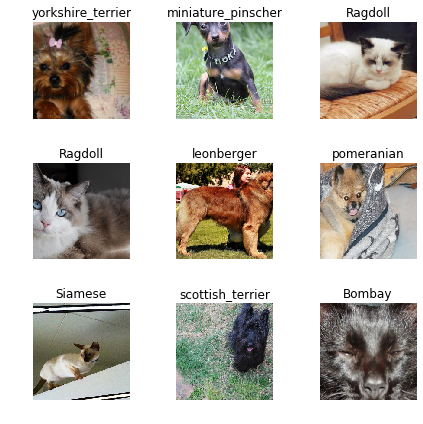

In [10]:
# Let's have a look at some random data
data.show_batch(3, figsize=(6,6))

## Training: resnet 34

Here we are training our dataset with a deep learning model called resnet. <br/>
It's an already train model which knows how to identify things in images.
So, we are going to build this on top of that. 

With that, we can reuse and do things speedly.<br>
This is something like, teaching a kid of speak a new lang who knows how to speak words.

In [11]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

Total time: 01:48
epoch  train loss  valid loss  error_rate
1      1.181966    0.296245    0.088624    (00:29)
2      0.500748    0.231448    0.075397    (00:26)
3      0.317551    0.209897    0.068122    (00:26)
4      0.232167    0.199673    0.066138    (00:26)



Here we've use `learn.fit_one_cycle` to start train our model. Usually we call a method called `fit` which is alaso available.

But `fit_one_cycle` is something new and 2018ish. (Jerammy said that :D)

Check the resuls above.
We are improving which each epoch(cycle). We can add a bigger number. But with that, we could get over fitting. 4 is a good default.

At the last one, our error rate is **6.8%**. Which is fucking cool.

In [15]:
# let's save this model. So, we don't need to start from scratch in the next time.
learn.save('lesson1-stage1')

## Inspect Result

Now we need to inspect some results and how we are doing here.

In [13]:
interpret = ClassificationInterpretation.from_learner(learn)

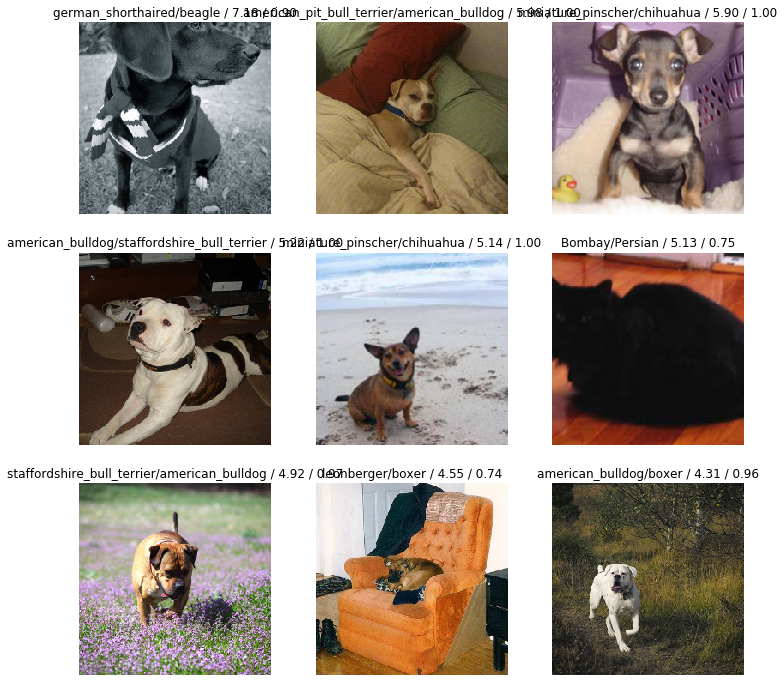

In [14]:
interpret.plot_top_losses(9, figsize=(12, 12))

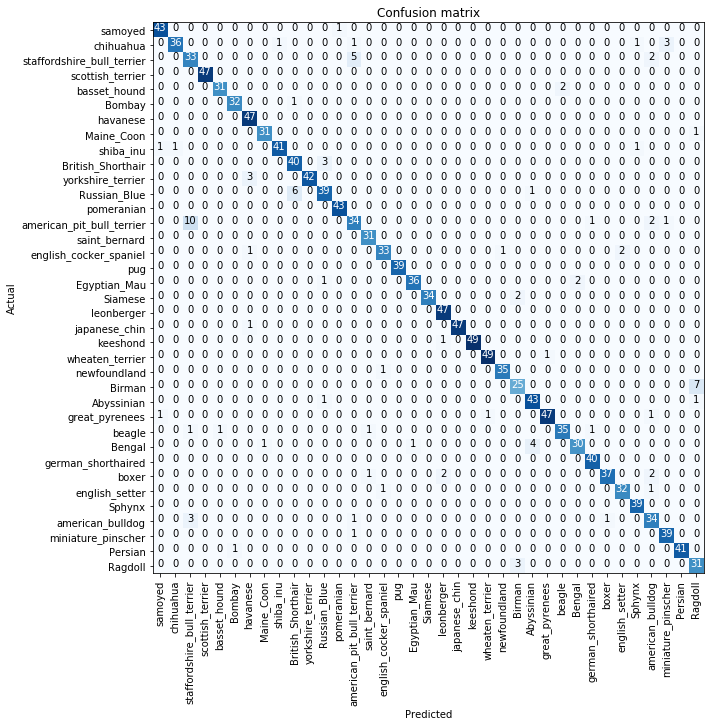

In [15]:
interpret.plot_confusion_matrix(figsize=(10, 10))

Even though it's pretty useful, we cannot get anything here. It's too much details.  <br/>
So, we need to reduce it. For that we use this:

In [16]:
interpret.most_confused(2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Birman', 'Ragdoll', 7),
 ('Russian_Blue', 'British_Shorthair', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('Bengal', 'Abyssinian', 4),
 ('chihuahua', 'miniature_pinscher', 3),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('yorkshire_terrier', 'havanese', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('Ragdoll', 'Birman', 3)]

Here's the topped items from the confusion metrics. It's pretty hard identify these guys even for us. <br/>
So, the computer did a great job.

## Unfreezing

Basically, in the previous section we only train our model on top of the last layer of the resnet34. (Which is 34). <br/>.
No we are trying to train our model on all of them.

In [17]:
## This is that.
learn.unfreeze()

In [18]:
learn.fit_one_cycle(1)

Total time: 00:27
epoch  train loss  valid loss  error_rate
1      1.054369    0.534908    0.162698    (00:27)



This is bad when we check without unfreezing. When freezed for the first later , we got onlu 8% of error. But here it's 16%.

### Learning Rate

Here, learning rate could be the problem. Let's have a look at it. <br/>
First let's checkout the learning rate for our previous model.

In [19]:
learn.load('lesson1-stage1')

In [20]:
learn.lr_find()

Here `lr_find()` will start training by increasing the learning rate. When it finds out the optimal learning rate, it'll stop training. <br/>
That's what we can see above.

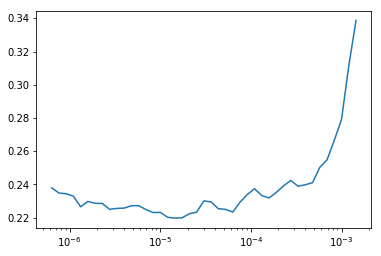

In [21]:
learn.recorder.plot()

As you can see above, the good learning rate is between 10^-6 to 10^-4.<br/>
But in the `.fit_one_cycle`, default learning rate is 10^-3. <br/>
That could be the reason for that. Let's try to change that.

In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 00:53
epoch  train loss  valid loss  error_rate
1      0.230301    0.116354    0.037037    (00:26)
2      0.206122    0.118560    0.039021    (00:27)



**That's a pretty good result**

### Case 1
Fit, unfreeze and fit with max_lr

In [26]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4)
learn2.unfreeze()
learn2.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 01:46
epoch  train loss  valid loss  error_rate
1      1.150927    0.282901    0.079365    (00:26)
2      0.490036    0.234885    0.077381    (00:26)
3      0.305139    0.209655    0.071429    (00:26)
4      0.231658    0.202433    0.070106    (00:27)



Total time: 00:54
epoch  train loss  valid loss  error_rate
1      0.195732    0.189211    0.062169    (00:27)
2      0.187931    0.186036    0.061508    (00:26)



### Case 2

Fit, unfreeze, fit

In [27]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4)
learn2.unfreeze()
learn2.fit_one_cycle(2)

Total time: 01:44
epoch  train loss  valid loss  error_rate
1      1.177395    0.301522    0.094577    (00:26)
2      0.487977    0.225668    0.084656    (00:25)
3      0.307252    0.189310    0.061508    (00:26)
4      0.229580    0.181239    0.058862    (00:26)



Total time: 00:54
epoch  train loss  valid loss  error_rate
1      1.131546    1.537658    0.421958    (00:27)
2      0.655043    0.354331    0.113757    (00:27)



### Case 3
Fit for 6 epochs directly

In [28]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(6)

Total time: 02:40
epoch  train loss  valid loss  error_rate
1      1.309131    0.334424    0.095238    (00:27)
2      0.553860    0.241669    0.080026    (00:26)
3      0.370115    0.205978    0.074735    (00:26)
4      0.270048    0.195635    0.068122    (00:26)
5      0.205317    0.182467    0.062169    (00:26)
6      0.171027    0.176030    0.059524    (00:27)



### Case 4

Fit, fit with max_lr

In [29]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4)
learn2.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 01:45
epoch  train loss  valid loss  error_rate
1      1.176917    0.295346    0.093915    (00:26)
2      0.517407    0.253855    0.085317    (00:26)
3      0.307675    0.209874    0.070106    (00:26)
4      0.229314    0.188363    0.057540    (00:26)



Total time: 00:54
epoch  train loss  valid loss  error_rate
1      0.210376    0.185917    0.059524    (00:26)
2      0.197916    0.187794    0.063492    (00:28)



### Case 5

unfreeze, fit with max_lr

In [31]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.unfreeze()
learn2.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 00:55
epoch  train loss  valid loss  error_rate
1      3.283320    2.054416    0.384259    (00:27)
2      2.250369    1.536628    0.271164    (00:27)



### Case 6

fit with max_lr from the beginning

In [32]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

Total time: 01:49
epoch  train loss  valid loss  error_rate
1      3.931007    3.084067    0.822090    (00:27)
2      2.802922    1.784122    0.335317    (00:27)
3      2.057958    1.349792    0.236772    (00:27)
4      1.782516    1.282479    0.226852    (00:27)

